In [42]:
from utils.roi import ROIProcessor

video_path = "/root/audio-visual-forensics/test.mp4"
model_path = "misc/face_landmarker.task"
landmarker = ROIProcessor(video_path, model_path)
R_means_dict, L_means_dict, M_means_dict, fps = landmarker.detect_with_calculate()

I0000 00:00:1734767550.168821   63825 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1734767550.169430   63825 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1734767550.182343   68865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734767550.204934   68881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing Frames: 100%|██████████| 134/134 [00:02<00:00, 47.20frame/s]


In [43]:
from utils.ppg import PPG_G, PPG_C

R_ROI_G_PPG = PPG_G(R_means_dict, fps).compute_signal()
print("R_ROI_G_PPG: ", len(R_ROI_G_PPG))

R_ROI_C_PPG = PPG_C(R_means_dict, fps).compute_signal()
print("R_ROI_C_PPG: ", len(R_ROI_C_PPG))

L_ROI_G_PPG = PPG_G(L_means_dict, fps).compute_signal()
print("L_ROI_G_PPG: ", len(L_ROI_G_PPG))

L_ROI_C_PPG = PPG_C(L_means_dict, fps).compute_signal()
print("L_ROI_C_PPG: ", len(L_ROI_C_PPG))

M_ROI_G_PPG = PPG_G(M_means_dict, fps).compute_signal()
print("M_ROI_G_PPG: ", len(M_ROI_G_PPG))

M_ROI_C_PPG = PPG_C(M_means_dict, fps).compute_signal()
print("M_ROI_C_PPG: ", len(M_ROI_C_PPG))

ZeroDivisionError: division by zero

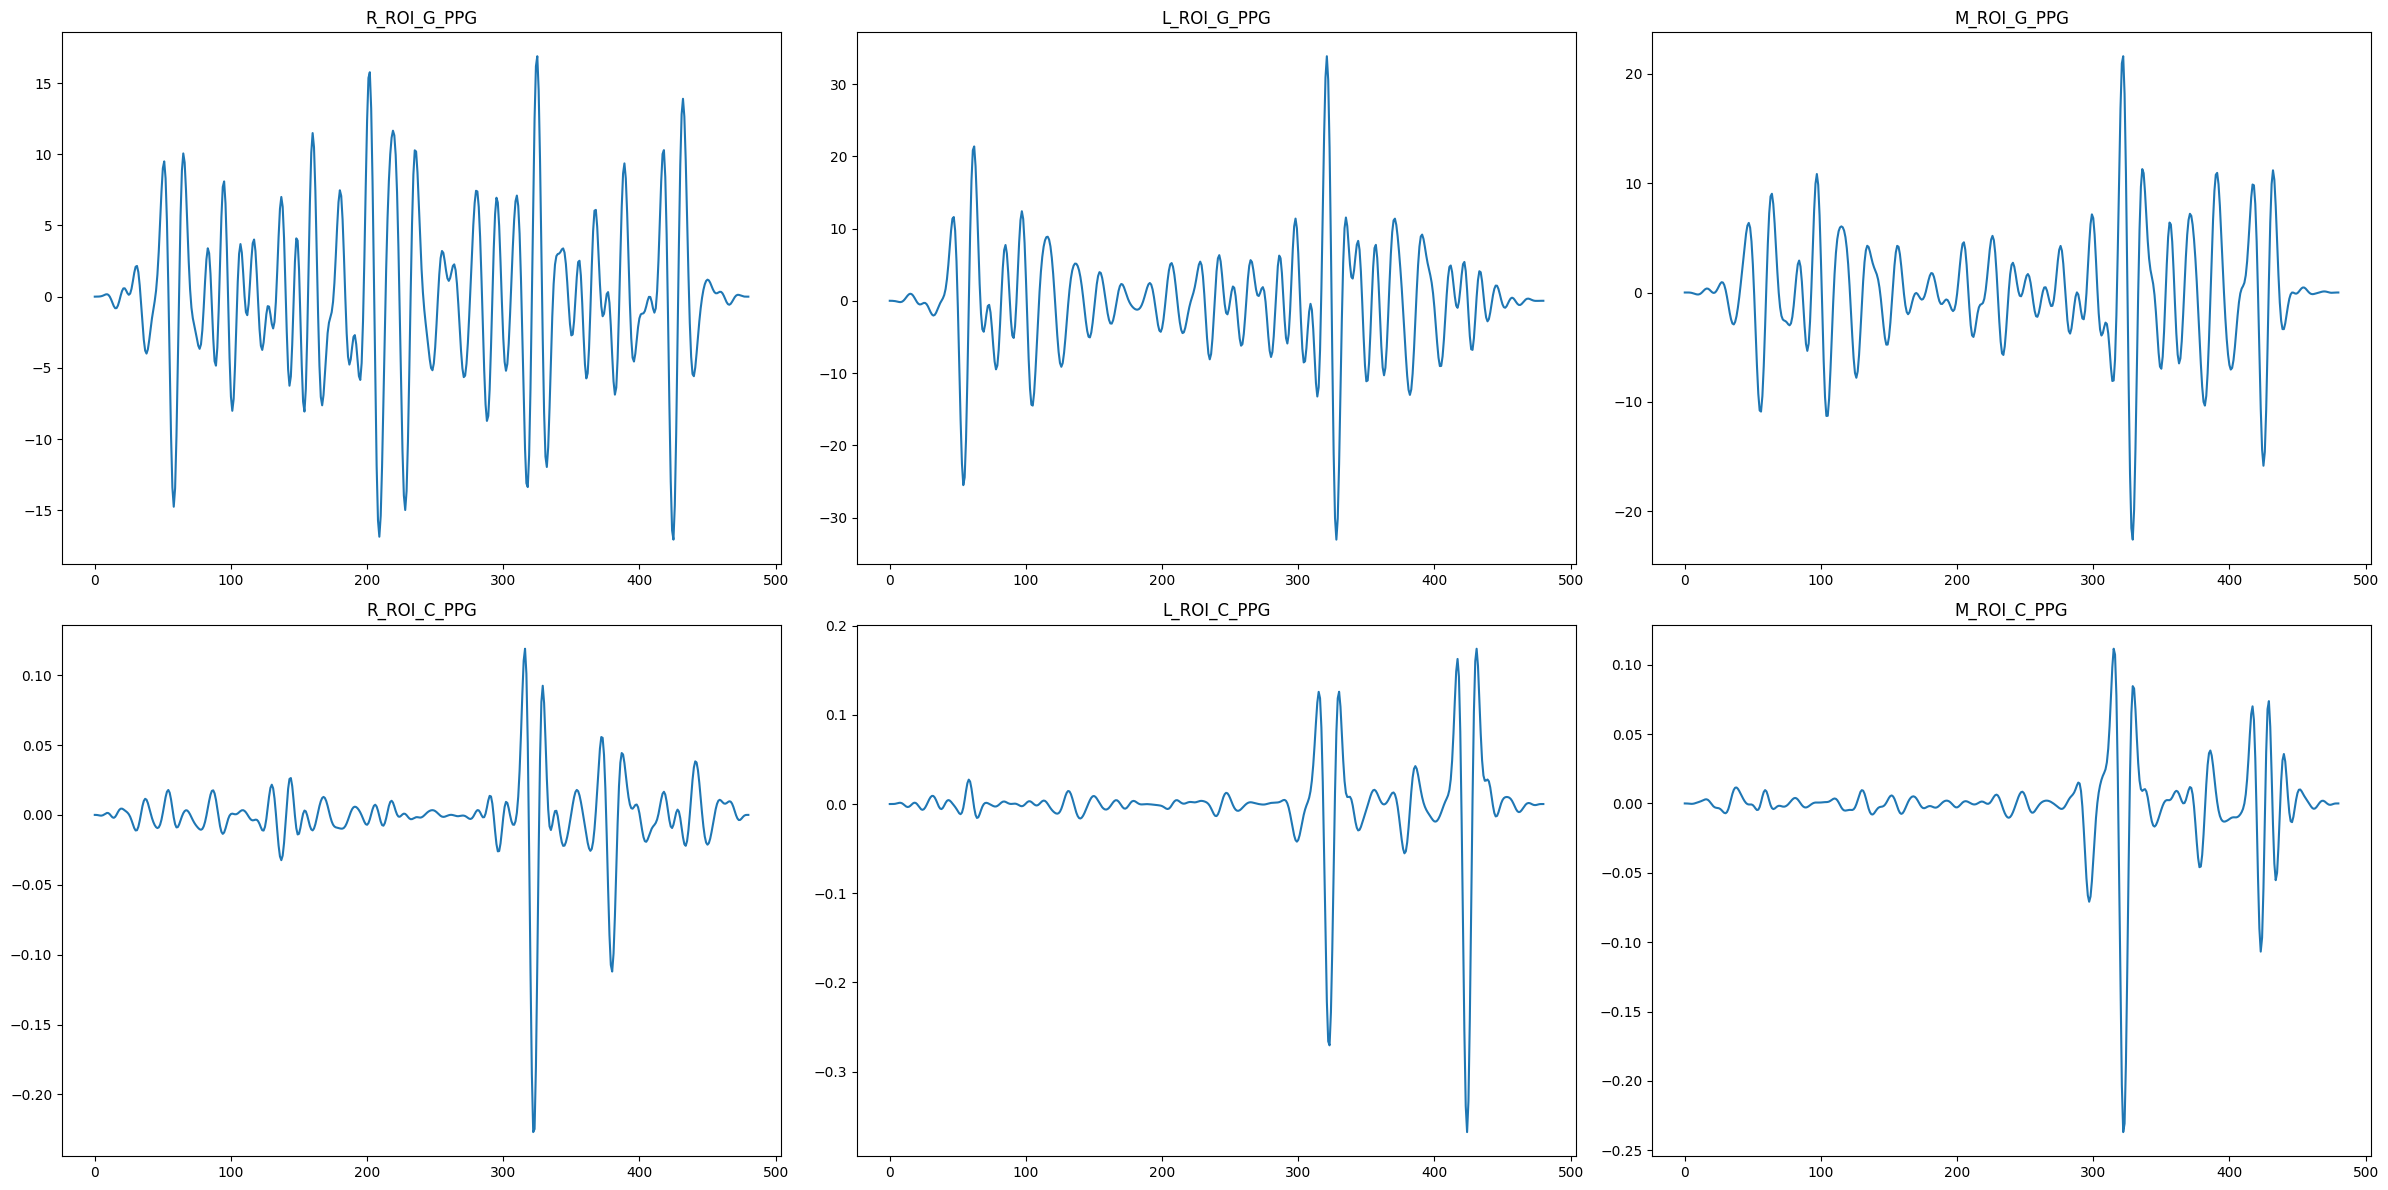

In [14]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots (2 rows and 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(24, 12))

# Plot data on the subplots
axs[0, 0].plot(R_ROI_G_PPG)
axs[0, 0].set_title('R_ROI_G_PPG')

axs[0, 1].plot(L_ROI_G_PPG)
axs[0, 1].set_title('L_ROI_G_PPG')

axs[0, 2].plot(M_ROI_G_PPG)
axs[0, 2].set_title('M_ROI_G_PPG')

axs[1, 0].plot(R_ROI_C_PPG)
axs[1, 0].set_title('R_ROI_C_PPG')

axs[1, 1].plot(L_ROI_C_PPG)
axs[1, 1].set_title('L_ROI_C_PPG')

axs[1, 2].plot(M_ROI_C_PPG)
axs[1, 2].set_title('M_ROI_C_PPG')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
import numpy as np
def split_segments(data, segment_length):
    """
    데이터를 segment_length 단위로 분할합니다. 
    남는 요소는 버립니다.
    
    Args:
        data (list or numpy.ndarray): 분할할 데이터.
        segment_length (int): 분할 크기.
        
    Returns:
        list: 분할된 세그먼트 리스트.
    """
    # 유효한 길이를 segment_length의 배수로 제한
    valid_length = len(data) - (len(data) % segment_length)
    return [np.array(data[i:i + segment_length]) for i in range(0, valid_length, segment_length)]


In [16]:
def combine_segments(*segments):
    """
    여러 세그먼트를 같은 인덱스 기준으로 묶습니다.

    Args:
        segments (list of lists): 여러 세그먼트 리스트.
    
    Returns:
        list of tuples: 인덱스별로 묶인 세그먼트 튜플 리스트.
    """
    return list(zip(*segments))

In [17]:
R_ROI_G_segments = split_segments(R_ROI_G_PPG, 72)
R_ROI_C_segments = split_segments(R_ROI_C_PPG, 72)
L_ROI_G_segments = split_segments(L_ROI_G_PPG, 72)
L_ROI_C_segments = split_segments(L_ROI_C_PPG, 72)
M_ROI_G_segments = split_segments(M_ROI_G_PPG, 72)
M_ROI_C_segments = split_segments(M_ROI_C_PPG, 72)

len(R_ROI_G_segments)

6

In [18]:
# 각 세그먼트 리스트를 결합
combined_segments = combine_segments(
    R_ROI_G_segments, 
    R_ROI_C_segments, 
    L_ROI_G_segments, 
    L_ROI_C_segments, 
    M_ROI_G_segments, 
    M_ROI_C_segments
)

# 첫 번째 묶인 결과 출력
print("첫 번째 묶인 세그먼트:", len(combined_segments[0]))

첫 번째 묶인 세그먼트: 6


In [ ]:
from utils.feature.feature_extractor import FeatureExtractor
features = []
for ppg in combined_segments:
    fe = FeatureExtractor(fps, *ppg)
    feature = fe.feature_union()
    features.append(feature)
features = np.array(features)
features.shape

/root/miniconda3/envs/video/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 72, using nperseg = 72
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


(6, 117)

In [25]:
labels = np.zeros(features.shape[0], dtype=int)
labels

array([1, 1, 1, 1, 1, 1])

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [34]:
X_train[0]

array([1.09338433e-19, 2.15149120e-17, 1.09844774e-19, 1.51657655e-18,
       1.73280104e-16, 1.50949600e-18, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.10000000e+01, 1.10000000e+01, 1.10000000e+01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.10000000e+01, 1.10000000e+01, 1.10000000e+01,
       4.29453747e+02, 4.29453747e+02, 4.29453747e+02, 4.29453747e+02,
       4.29453747e+02, 4.29453747e+02, 2.89778569e-01, 4.39760794e-01,
       2.89453527e-01, 3.09206698e+04, 3.09206698e+04, 3.09206698e+04,
       3.09206698e+04, 3.09206698e+04, 3.09206698e+04, 3.11163927e+00,
       4.29881091e+00, 3.09796293e+00, 5.96731941e-09, 6.43874713e-09,
       3.27234974e-11, 9.87195524e-11, 3.44723188e-11, 6.74710346e-09,
       2.07771477e-01, 2.44248811e-01, 2.07313863e-01, 5.49617558e-10,
       7.97503910e-10, 1.11195568e-11, 9.88766577e-12, 4.80355531e-12,
      

In [36]:
from sklearn.svm import SVR

svr = SVR()
for feature, label in zip(X_train, y_train):
    svr.fit([feature], [label])

In [28]:
def majority_voting(probabilities):
    """
    Perform majority voting on the predicted probabilities.
    """
    mean_prob = np.mean(probabilities)
    majority_vote = np.round(mean_prob)
    return majority_vote

In [37]:
segment_probabilities = []

for feature in features:
    prob = svr.predict([feature])[0]  # SVR 모델로 예측
    segment_probabilities.append(prob)

video_label = majority_voting(segment_probabilities)

print("Segment Probabilities:", segment_probabilities)
print("Final Video Label:", video_label)

Segment Probabilities: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Final Video Label: 1.0
